# Fiona Nicdao's Assignment 2

In [1]:
import numpy as np
import tensorflow as tf
import pandas as pd
from tensorflow import  keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import time

## Processing the MNIST Dataset

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


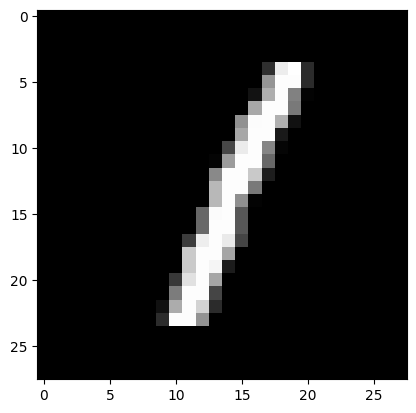

(39200, 784)
(39200, 10)
(21000, 784)
(21000, 10)


In [2]:
#build the model based on the data

(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

# Change the data to be split into 70% training set and 30% testing set
x = np.concatenate((x_train, x_test))
y = np.concatenate((y_train, y_test))
train_size = 0.7
x_train, x_test, y_train, y_test = train_test_split(x, y, train_size=train_size,
                                                    random_state=42)

dev_size = 0.8 * x_train.shape[0]
dev_size = int(dev_size)

#shuffle the x_train (good practice)
#seed for reproducibility
indices = np.arange(x_train.shape[0])
np.random.shuffle(indices)
x_train = x_train[indices]
y_train = y_train[indices]

# plot the image
plt.imshow(x_train[0], cmap='gray')
plt.show()

#dividing the training dataset into 80/20 : training set/ validation set
x_val = x_train[dev_size:] #validation sets
y_val = y_train[dev_size:]

x_train = x_train[:dev_size] #training sets
y_train = y_train[:dev_size]

#preparing training data
#dividing them by max pixel value as a float to get all values btw 0 and 1
x_train = (x_train/255.0).reshape(-1, 28*28)
x_val = (x_val/255.0).reshape(-1, 28*28)
x_test = (x_test/255.0).reshape(-1, 28*28)

#make the classes one-hot encodings
y_train = tf.keras.utils.to_categorical(y_train)
y_val = tf.keras.utils.to_categorical(y_val)
y_test = tf.keras.utils.to_categorical(y_test)

print(x_train.shape) #6000 training samples, image is 28x28 size
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)


In [3]:
#check step that the data is normalized between [1.0, 0.0]
x_train[0].max(), x_train[0].min()
# better to have it float values /

(1.0, 0.0)

## Building the Model : MLP

In [4]:
#model
class MLP(tf.keras.Model):
  def __init__(self, num_classes, input_shape, n_layers, n_units, activation,
               optim, loss, initializer,reg):
      super(MLP, self).__init__()
      self.num_classes = num_classes
      self.input_shape = input_shape
      self.n_layers = n_layers
      self.n_units = n_units
      self.activation = activation
      self.optimizer = optim
      self.loss = loss
      self.initializer = initializer
      self.regularizer = reg

      self.model = self.create_model()

  #build the structure of the model
  def create_model(self):
    model = tf.keras.Sequential() # Sequential model is just a placeholder
    model.add(tf.keras.layers.Input(shape=self.input_shape))

    for i in range(self.n_layers):
      model.add(tf.keras.layers.Dense(self.n_units,
                                      input_shape=self.input_shape,
                                      activation=self.activation,
                                      kernel_initializer = self.initializer,
                                      kernel_regularizer= self.regularizer))

    model.add(tf.keras.layers.Dense(self.num_classes, activation='softmax'))

    return model

  def compile_model(self):
    self.model.compile(optimizer=self.optimizer, loss=self.loss,
                       metrics=['accuracy'])

  def train_model(self, x_train, y_train, x_val, y_val, epochs=10,
                  batch_size=32):
    self.model.fit(x_train, y_train, epochs=epochs, batch_size=64,
                   validation_data=(x_val, y_val))

  def evaluate_model(self, x_test, y_test):
    test_loss, test_acc = self.model.evaluate(x_test, y_test)
    return test_loss, test_acc

# Task 1
## compare the performance of 2-layer vs 3-layer vs 4-layer MLPs on MNIST dataset


In [5]:
# make a dataframe to compare the accuracy and loss for all the different activation
df = pd.DataFrame(columns=['Number of Layers', 'Loss', 'Accuracy','Time'])
df['Number of Layers'] = df['Number of Layers'].astype(np.int32)

In [6]:
layers = [2, 3, 4]
for layer in layers:
  mlp_layer = MLP(num_classes=10,
            input_shape=(28*28,),
            n_layers=layer,
            n_units=100,
            activation='relu',
            optim= tf.keras.optimizers.Adam(learning_rate=0.0002),
            loss=tf.keras.losses.CategoricalCrossentropy(),
            initializer=tf.keras.initializers.RandomNormal(),
            reg = tf.keras.regularizers.l2(0.001))
  mlp_layer.compile_model()
  start = time.time()
  mlp_layer.train_model(x_train, y_train, x_val, y_val, epochs=50, batch_size=32)
  end = time.time()
  print(f"Training time for MLP {layer}-layer : {end - start} seconds")
  test_loss, test_acc = mlp_layer.evaluate_model(x_test, y_test)
  df.loc[len(df)] = [layer, test_loss, test_acc, end - start]
  mlp_layer.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
613/613 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - accuracy: 0.6814 - loss: 1.3749 - val_accuracy: 0.9048 - val_loss: 0.4714
Epoch 2/50
613/613 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.9173 - loss: 0.4341 - val_accuracy: 0.9283 - val_loss: 0.3835
Epoch 3/50
613/613 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.9333 - loss: 0.3576 - val_accuracy: 0.9367 - val_loss: 0.3419
Epoch 4/50
613/613 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.9426 - loss: 0.3217 - val_accuracy: 0.9450 - val_loss: 0.3131
Epoch 5/50
613/613 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.9496 - loss: 0.2905 - val_accuracy: 0.9470 - val_loss: 0.2953
Epoch 6/50
613/613 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.9535 - loss: 0.2714 - val_accuracy: 0.9497 - val_loss: 0.2780
Epoch 7/50
613/613 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.9607 - loss: 0.2483 - val_accuracy: 0.9532 - val_loss: 0.2664
Epoch 8/50
613/613 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.9639 - loss: 0.2349 - val_accuracy: 0.

Model: "mlp"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential (Sequential)              │ (None, 10)                  │          89,610 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 89,610 (350.04 KB)

 Trainable params: 89,610 (350.04 KB)

 Non-trainable params: 0 (0.00 B)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
613/613 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.6558 - loss: 1.4571 - val_accuracy: 0.9034 - val_loss: 0.4963
Epoch 2/50
613/613 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.9133 - loss: 0.4658 - val_accuracy: 0.9232 - val_loss: 0.4101
Epoch 3/50
613/613 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.9333 - loss: 0.3832 - val_accuracy: 0.9334 - val_loss: 0.3684
Epoch 4/50
613/613 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.9428 - loss: 0.3383 - val_accuracy: 0.9436 - val_loss: 0.3336
Epoch 5/50
613/613 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.9528 - loss: 0.3051 - val_accuracy: 0.9453 - val_loss: 0.3178
Epoch 6/50
613/613 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.9555 - loss: 0.2829 - val_accuracy: 0.9491 - val_loss: 0.2950
Epoch 7/50
613/613 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.9635 - loss: 0.2574 - val_accuracy: 0.9526 - val_loss: 0.2837
Epoch 8/50
613/613 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.9646 - loss: 0.2457 - val_accuracy: 0.

Model: "mlp_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential_1 (Sequential)            │ (None, 10)                  │          99,710 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 99,710 (389.49 KB)

 Trainable params: 99,710 (389.49 KB)

 Non-trainable params: 0 (0.00 B)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
613/613 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - accuracy: 0.6260 - loss: 1.5165 - val_accuracy: 0.8962 - val_loss: 0.5474
Epoch 2/50
613/613 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.9102 - loss: 0.4913 - val_accuracy: 0.9224 - val_loss: 0.4422
Epoch 3/50
613/613 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.9306 - loss: 0.4127 - val_accuracy: 0.9315 - val_loss: 0.3979
Epoch 4/50
613/613 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.9419 - loss: 0.3628 - val_accuracy: 0.9410 - val_loss: 0.3564
Epoch 5/50
613/613 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.9529 - loss: 0.3189 - val_accuracy: 0.9455 - val_loss: 0.3365
Epoch 6/50
613/613 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.9599 - loss: 0.2927 - val_accuracy: 0.9537 - val_loss: 0.3049
Epoch 7/50
613/613 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.9642 - loss: 0.2712 - val_accuracy: 0.9536 - val_loss: 0.2980
Epoch 8/50
613/613 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.9676 - loss: 0.2543 - val_accuracy: 0.

Model: "mlp_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential_2 (Sequential)            │ (None, 10)                  │         109,810 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 109,810 (428.95 KB)

 Trainable params: 109,810 (428.95 KB)

 Non-trainable params: 0 (0.00 B)

In [7]:
df['Number of Layers'] = df['Number of Layers'].astype(np.int32)
print(df)

   Number of Layers      Loss  Accuracy        Time
0                 2  0.145159  0.974667  222.539895
1                 3  0.160991  0.974095  221.925477
2                 4  0.194211  0.968095  267.954012


Results:  Minimum difference with the loss and accuracy for all three different layers. 2-layer has the fastest time and 4-layer has the slowest time.

# TASK 2
## Compare the performance of 2-layer MLP when using different settings

### different weight initialization (RandomNormal, zeros, ones, GlorotNormal)
### different regularization (l1, l2, l1_l2)
### different optimizers (SDG , ADAM, Ftrl)

### Default weight initialization: RandomNormal
### Default regularization: l2
### Default optimizer: SDG

In [8]:
# make a dataframe to compare the accuracy and loss for all the different activation
df_task2 = pd.DataFrame(columns=['weight init','regularization',
                           'optimizer', 'Loss', 'Accuracy','Time'])

### Different Weight Initialization (RandomNormal, zeros, ones, GlorotNormal)

In [10]:
# try : RandomNormal, zeros, ones, GlorotNormal

intialweights = [{'name': 'RandomNormal','obj':tf.keras.initializers.RandomNormal()},
                 {'name': 'zeros','obj':tf.keras.initializers.zeros()},
                 {'name': 'ones','obj':tf.keras.initializers.ones()},
                 {'name': 'GlorotNormal','obj':tf.keras.initializers.GlorotNormal()}]
for idx, initweight in enumerate(intialweights):
  mlp_idx = MLP(num_classes=10,
            input_shape=(28*28,),
            n_layers=2,
            n_units=100,
            activation='relu',
            optim= tf.keras.optimizers.SGD(learning_rate=0.0002),
            loss=tf.keras.losses.CategoricalCrossentropy(),
            initializer=initweight['obj'],
            reg = tf.keras.regularizers.l2(0.001))

  mlp_idx.compile_model()

  start = time.time()
  mlp_idx.train_model(x_train, y_train, x_val, y_val, epochs=50, batch_size=32)
  end = time.time()

  print(f"Training time for MLP_{idx} task 2 {initweight['name']} is the weight intialization: {end - start} seconds")
  print("\n")

  test_loss, test_acc = mlp_idx.evaluate_model(x_test, y_test)

  df_task2.loc[len(df_task2)] =[initweight['name'],'l2', 'SGD',test_loss, test_acc, end - start]

  mlp_idx.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
613/613 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.0753 - loss: 2.5274 - val_accuracy: 0.1037 - val_loss: 2.5120
Epoch 2/50
613/613 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.1086 - loss: 2.5082 - val_accuracy: 0.1438 - val_loss: 2.4939
Epoch 3/50
613/613 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.1501 - loss: 2.4906 - val_accuracy: 0.1879 - val_loss: 2.4758
Epoch 4/50
613/613 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.1913 - loss: 2.4730 - val_accuracy: 0.2369 - val_loss: 2.4573
Epoch 5/50
613/613 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.2411 - loss: 2.4548 - val_accuracy: 0.2867 - val_loss: 2.4381
Epoch 6/50
613/613 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.2917 - loss: 2.4354 - val_accuracy: 0.3361 - val_loss: 2.4179
Epoch 7/50
613/613 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.3441 - loss: 2.4151 - val_accuracy: 0.3886 - val_loss: 2.3962
Epoch 8/50
613/613 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.3923 - loss: 2.3925 - val_accuracy: 0.

Model: "mlp_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential_3 (Sequential)            │ (None, 10)                  │          89,610 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 89,610 (350.04 KB)

 Trainable params: 89,610 (350.04 KB)

 Non-trainable params: 0 (0.00 B)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
613/613 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.1098 - loss: 2.3026 - val_accuracy: 0.1106 - val_loss: 2.3026
Epoch 2/50
613/613 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.1130 - loss: 2.3025 - val_accuracy: 0.1106 - val_loss: 2.3025
Epoch 3/50
613/613 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.1130 - loss: 2.3025 - val_accuracy: 0.1106 - val_loss: 2.3025
Epoch 4/50
613/613 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.1157 - loss: 2.3025 - val_accuracy: 0.1106 - val_loss: 2.3025
Epoch 5/50
613/613 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.1105 - loss: 2.3025 - val_accuracy: 0.1106 - val_loss: 2.3024
Epoch 6/50
613/613 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.1134 - loss: 2.3024 - val_accuracy: 0.1106 - val_loss: 2.3024
Epoch 7/50
613/613 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.1138 - loss: 2.3024 - val_accuracy: 0.1106 - val_loss: 2.3024
Epoch 8/50
613/613 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.1166 - loss: 2.3023 - val_accuracy: 0.

Model: "mlp_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential_4 (Sequential)            │ (None, 10)                  │          89,610 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 89,610 (350.04 KB)

 Trainable params: 89,610 (350.04 KB)

 Non-trainable params: 0 (0.00 B)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
613/613 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.0985 - loss: 143832.5156 - val_accuracy: 0.1001 - val_loss: 70.9219
Epoch 2/50
613/613 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.1011 - loss: 70.8767 - val_accuracy: 0.1003 - val_loss: 70.7490
Epoch 3/50
613/613 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.0990 - loss: 70.5939 - val_accuracy: 0.1001 - val_loss: 70.5533
Epoch 4/50
613/613 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.0987 - loss: 70.5219 - val_accuracy: 0.0990 - val_loss: 70.4816
Epoch 5/50
613/613 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.0991 - loss: 70.4642 - val_accuracy: 0.1031 - val_loss: 70.4063
Epoch 6/50
613/613 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.1001 - loss: 70.3981 - val_accuracy: 0.1031 - val_loss: 70.3647
Epoch 7/50
613/613 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.0987 - loss: 70.3612 - val_accuracy: 0.1031 - val_loss: 70.3306
Epoch 8/50
613/613 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.1002 - loss: 70.3262

Model: "mlp_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential_5 (Sequential)            │ (None, 10)                  │          89,610 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 89,610 (350.04 KB)

 Trainable params: 89,610 (350.04 KB)

 Non-trainable params: 0 (0.00 B)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
613/613 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.1149 - loss: 2.5698 - val_accuracy: 0.1449 - val_loss: 2.5286
Epoch 2/50
613/613 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.1515 - loss: 2.5166 - val_accuracy: 0.1973 - val_loss: 2.4777
Epoch 3/50
613/613 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.2089 - loss: 2.4678 - val_accuracy: 0.2655 - val_loss: 2.4268
Epoch 4/50
613/613 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.2821 - loss: 2.4177 - val_accuracy: 0.3437 - val_loss: 2.3745
Epoch 5/50
613/613 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.3607 - loss: 2.3629 - val_accuracy: 0.4255 - val_loss: 2.3200
Epoch 6/50
613/613 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.4455 - loss: 2.3089 - val_accuracy: 0.4961 - val_loss: 2.2625
Epoch 7/50
613/613 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.5078 - loss: 2.2506 - val_accuracy: 0.5484 - val_loss: 2.2019
Epoch 8/50
613/613 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.5588 - loss: 2.1868 - val_accuracy: 0.

Model: "mlp_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential_6 (Sequential)            │ (None, 10)                  │          89,610 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 89,610 (350.04 KB)

 Trainable params: 89,610 (350.04 KB)

 Non-trainable params: 0 (0.00 B)

### Different regularizations (l1, l2, l1_l2)

In [11]:
# try : l1, l2, l1_l2
reguleriers = [{'name': 'l1', 'obj': tf.keras.regularizers.l1(0.001)},
               {'name': 'l2', 'obj': tf.keras.regularizers.l2(0.001)},
               {'name': 'l1_l2', 'obj': tf.keras.regularizers.l1_l2(0.001)}]
for idx, reg in enumerate(reguleriers):
  mlp_idx = MLP(num_classes=10,
            input_shape=(28*28,),
            n_layers=2,
            n_units=100,
            activation='relu',
            optim= tf.keras.optimizers.SGD(learning_rate=0.0002),
            loss=tf.keras.losses.CategoricalCrossentropy(),
            initializer=tf.keras.initializers.RandomNormal(),
            reg = reg['obj'])

  mlp_idx.compile_model()

  start = time.time()
  mlp_idx.train_model(x_train, y_train, x_val, y_val, epochs=50, batch_size=32)
  end = time.time()

  print(f"Training time for MLP task 2 {reg['name']} regularization: {end - start} seconds")
  print("\n")

  test_loss, test_acc = mlp_idx.evaluate_model(x_test, y_test)

  df_task2.loc[len(df_task2)] =['RandomNormal',reg['name'], 'SGD',test_loss, test_acc, end - start]

  mlp_idx.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
613/613 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.1211 - loss: 5.7893 - val_accuracy: 0.1557 - val_loss: 5.7675
Epoch 2/50
613/613 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.1647 - loss: 5.7595 - val_accuracy: 0.2043 - val_loss: 5.7385
Epoch 3/50
613/613 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.2127 - loss: 5.7306 - val_accuracy: 0.2474 - val_loss: 5.7093
Epoch 4/50
613/613 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.2556 - loss: 5.7016 - val_accuracy: 0.2880 - val_loss: 5.6796
Epoch 5/50
613/613 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.2946 - loss: 5.6724 - val_accuracy: 0.3239 - val_loss: 5.6492
Epoch 6/50
613/613 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.3321 - loss: 5.6407 - val_accuracy: 0.3536 - val_loss: 5.6177
Epoch 7/50
613/613 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.3609 - loss: 5.6095 - val_accuracy: 0.3883 - val_loss: 5.5850
Epoch 8/50
613/613 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.3913 - loss: 5.5777 - val_accuracy: 0.

Model: "mlp_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential_7 (Sequential)            │ (None, 10)                  │          89,610 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 89,610 (350.04 KB)

 Trainable params: 89,610 (350.04 KB)

 Non-trainable params: 0 (0.00 B)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
613/613 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.0961 - loss: 2.5239 - val_accuracy: 0.1002 - val_loss: 2.5088
Epoch 2/50
613/613 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.1028 - loss: 2.5042 - val_accuracy: 0.1086 - val_loss: 2.4890
Epoch 3/50
613/613 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.1183 - loss: 2.4823 - val_accuracy: 0.1291 - val_loss: 2.4694
Epoch 4/50
613/613 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.1352 - loss: 2.4653 - val_accuracy: 0.1630 - val_loss: 2.4496
Epoch 5/50
613/613 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.1689 - loss: 2.4456 - val_accuracy: 0.2077 - val_loss: 2.4291
Epoch 6/50
613/613 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.2129 - loss: 2.4248 - val_accuracy: 0.2497 - val_loss: 2.4077
Epoch 7/50
613/613 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.2597 - loss: 2.4025 - val_accuracy: 0.2978 - val_loss: 2.3850
Epoch 8/50
613/613 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.3079 - loss: 2.3813 - val_accuracy: 0.

Model: "mlp_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential_8 (Sequential)            │ (None, 10)                  │          89,610 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 89,610 (350.04 KB)

 Trainable params: 89,610 (350.04 KB)

 Non-trainable params: 0 (0.00 B)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
613/613 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.1314 - loss: 5.8405 - val_accuracy: 0.1570 - val_loss: 5.8116
Epoch 2/50
613/613 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.1596 - loss: 5.8051 - val_accuracy: 0.1866 - val_loss: 5.7767
Epoch 3/50
613/613 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.1915 - loss: 5.7702 - val_accuracy: 0.2149 - val_loss: 5.7423
Epoch 4/50
613/613 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.2183 - loss: 5.7372 - val_accuracy: 0.2526 - val_loss: 5.7078
Epoch 5/50
613/613 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.2590 - loss: 5.7024 - val_accuracy: 0.2999 - val_loss: 5.6726
Epoch 6/50
613/613 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.3060 - loss: 5.6660 - val_accuracy: 0.3533 - val_loss: 5.6362
Epoch 7/50
613/613 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.3584 - loss: 5.6288 - val_accuracy: 0.3944 - val_loss: 5.5983
Epoch 8/50
613/613 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.3968 - loss: 5.5917 - val_accuracy: 0.

Model: "mlp_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential_9 (Sequential)            │ (None, 10)                  │          89,610 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 89,610 (350.04 KB)

 Trainable params: 89,610 (350.04 KB)

 Non-trainable params: 0 (0.00 B)

### Different optimizers (SDG , ADAM, Ftrl)

In [12]:
#try : SDG , ADAM, Ftrl
optimizers = [{'name':'SGD','obj':tf.keras.optimizers.SGD(learning_rate=0.0001)},
              {'name':'Adam','obj':tf.keras.optimizers.Adam(learning_rate=0.0001)},
              {'name':'Ftrl','obj':tf.keras.optimizers.Ftrl(learning_rate=0.0001)}]
for idx, optimizer in enumerate(optimizers):
  mlp_idx = MLP(num_classes=10,
            input_shape=(28*28,),
            n_layers=2,
            n_units=100,
            activation='relu',
            optim= optimizer['obj'],
            loss=tf.keras.losses.CategoricalCrossentropy(),
            initializer=tf.keras.initializers.RandomNormal(),
            reg = tf.keras.regularizers.l2(0.001))

  mlp_idx.compile_model()

  start = time.time()
  mlp_idx.train_model(x_train, y_train, x_val, y_val, epochs=50, batch_size=32)
  end = time.time()

  print(f"Training time for MLP task 2 {optimizer['name']} is the optimizer: {end - start} seconds")
  print("\n")

  test_loss, test_acc = mlp_idx.evaluate_model(x_test, y_test)

  df_task2.loc[len(df_task2)] =['RandomNormal', 'l2', optimizer['name'],test_loss, test_acc,end - start]

  mlp_idx.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
613/613 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.1043 - loss: 2.5367 - val_accuracy: 0.1174 - val_loss: 2.5288
Epoch 2/50
613/613 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.1216 - loss: 2.5233 - val_accuracy: 0.1373 - val_loss: 2.5143
Epoch 3/50
613/613 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.1385 - loss: 2.5095 - val_accuracy: 0.1605 - val_loss: 2.5003
Epoch 4/50
613/613 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.1617 - loss: 2.4936 - val_accuracy: 0.1857 - val_loss: 2.4866
Epoch 5/50
613/613 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.1875 - loss: 2.4814 - val_accuracy: 0.2118 - val_loss: 2.4730
Epoch 6/50
613/613 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.2124 - loss: 2.4673 - val_accuracy: 0.2390 - val_loss: 2.4596
Epoch 7/50
613/613 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.2413 - loss: 2.4546 - val_accuracy: 0.2691 - val_loss: 2.4461
Epoch 8/50
613/613 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.2641 - loss: 2.4432 - val_accuracy: 0.

Model: "mlp_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential_10 (Sequential)           │ (None, 10)                  │          89,610 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 89,610 (350.04 KB)

 Trainable params: 89,610 (350.04 KB)

 Non-trainable params: 0 (0.00 B)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
613/613 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.5691 - loss: 1.7468 - val_accuracy: 0.8809 - val_loss: 0.6066
Epoch 2/50
613/613 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.8920 - loss: 0.5570 - val_accuracy: 0.9048 - val_loss: 0.4760
Epoch 3/50
613/613 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.9120 - loss: 0.4560 - val_accuracy: 0.9160 - val_loss: 0.4267
Epoch 4/50
613/613 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.9246 - loss: 0.4090 - val_accuracy: 0.9212 - val_loss: 0.4010
Epoch 5/50
613/613 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.9288 - loss: 0.3812 - val_accuracy: 0.9305 - val_loss: 0.3705
Epoch 6/50
613/613 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.9367 - loss: 0.3512 - val_accuracy: 0.9360 - val_loss: 0.3491
Epoch 7/50
613/613 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.9420 - loss: 0.3260 - val_accuracy: 0.9401 - val_loss: 0.3312
Epoch 8/50
613/613 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.9463 - loss: 0.3100 - val_accuracy: 0.

Model: "mlp_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential_11 (Sequential)           │ (None, 10)                  │          89,610 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 89,610 (350.04 KB)

 Trainable params: 89,610 (350.04 KB)

 Non-trainable params: 0 (0.00 B)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
613/613 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - accuracy: 0.1119 - loss: 2.3050 - val_accuracy: 0.1106 - val_loss: 2.3026
Epoch 2/50
613/613 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - accuracy: 0.1126 - loss: 2.3026 - val_accuracy: 0.1106 - val_loss: 2.3025
Epoch 3/50
613/613 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.1136 - loss: 2.3025 - val_accuracy: 0.1106 - val_loss: 2.3025
Epoch 4/50
613/613 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.1101 - loss: 2.3025 - val_accuracy: 0.1106 - val_loss: 2.3025
Epoch 5/50
613/613 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.1130 - loss: 2.3025 - val_accuracy: 0.1106 - val_loss: 2.3025
Epoch 6/50
613/613 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.1151 - loss: 2.3025 - val_accuracy: 0.1106 - val_loss: 2.3025
Epoch 7/50
613/613 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.1147 - loss: 2.3025 - val_accuracy: 0.1106 - val_loss: 2.3025
Epoch 8/50
613/613 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.1132 - loss: 2.3025 - val_accuracy: 0.

Model: "mlp_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential_12 (Sequential)           │ (None, 10)                  │          89,610 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 89,610 (350.04 KB)

 Trainable params: 89,610 (350.04 KB)

 Non-trainable params: 0 (0.00 B)

## Compare the accuracy, loss, time for all the different designs

In [13]:
print(df_task2)

    weight init regularization optimizer       Loss  Accuracy        Time
0  RandomNormal             l2       SGD   0.916861  0.832571  207.002571
1         zeros             l2       SGD   2.301564  0.112571  210.118195
2          ones             l2       SGD  68.859261  0.133190  197.121671
3  GlorotNormal             l2       SGD   0.826403  0.858667  209.670606
4  RandomNormal             l1       SGD   3.832839  0.813619  200.443092
5  RandomNormal             l2       SGD   0.918872  0.827619  219.046928
6  RandomNormal          l1_l2       SGD   3.824388  0.827762  197.279004
7  RandomNormal             l2       SGD   1.538223  0.706000  216.737974
8  RandomNormal             l2      Adam   0.174193  0.970571  226.360673
9  RandomNormal             l2      Ftrl   2.302361  0.112571  249.816703


# Results:
The best for this dataset is ...

Best weight initalization by max accuracy and min loss is **GlorotNormal**.

Regularization accuracy is about the same for all (l1, l2, l3) with **l2** with the lowest loss and the fastest time is **l1_l2**.

Best optimizer is **Adam** with the highest accuracy at 97% and lowest loss.  
